This notebook is for plotting spatial maps of tracer anomalies and their vertical profiles.

In [1]:
import xarray as xr
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import xmip.preprocessing as xmip
import glob
import xskillscore as xs

import matplotlib.image as image
import matplotlib.patches as patches

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings("ignore")

In [31]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended
    

def plot_sec(ax, da, da_std = None, hatching = False, hatch_dense = 2, cfd_per = 1.96, vmin=-999, vmax=999, levels=9, 
             lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', orien='vertical', colorbar=True,
             y_lab = True, x_lab = True, grid_line = True):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    if(hatching == True):
        tmp_cfd = da_std * cfd_per # 95% for outside 1.96 x sigma
        ax.contourf(da[lon], da[lat], np.abs(da) > np.abs(tmp_cfd), transform=ccrs.PlateCarree(), colors='none', 
                    levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
        
    # add separate colorbar
    if(colorbar==True):
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=1.0, orientation=orien)
        cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    if(grid_line == True):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1., color='gray', alpha=0.1, linestyle='--')
            
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    gl.ylocator = mticker.FixedLocator([70, 50, 30, 10])
    gl.xlocator = mticker.FixedLocator([-80, -60, -40, -20, 0])
    
    if(y_lab==False):
        gl.ylocator = mticker.FixedLocator([])
    if(x_lab==False):
        gl.xlocator = mticker.FixedLocator([])
    
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return p

## Figure: Time-variability (historical period UKESM) of CO2 flux, surface DIC, heat flux, SST. 

Use this point to difficulty of revealing causality of atmospheric forcing and ocean response (or vice versa).

In [3]:
# Read domain-averaged time-series data 

ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/" + 
         "r2i1p1f2/Timeseries/")

cmip_dir = "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/"

ds = xr.open_dataset(ppdir + "North_Atlantic_thetao_DIC.nc")

ds_clim = ds.groupby('time.month').mean('time')
ds = ds.groupby('time.month') - ds_clim # remove climatology

print(ds)

<xarray.Dataset>
Dimensions:  (time: 1980)
Coordinates:
  * time     (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
    lev      (time) float64 0.5058 0.5058 0.5058 0.5058 ... 0.5058 0.5058 0.5058
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    thetao   (time) float64 -0.009567 0.00728 0.09688 ... 1.177 0.9993 0.8844
    dissic   (time) float64 -0.02339 -0.02261 -0.02337 ... 0.04902 0.04878
    hfds     (time) float64 10.76 -10.18 13.31 7.647 ... -0.859 -8.269 -3.249
    fgco2    (time) float64 -7.878e-11 -1.628e-10 ... 1.39e-10 3.448e-10


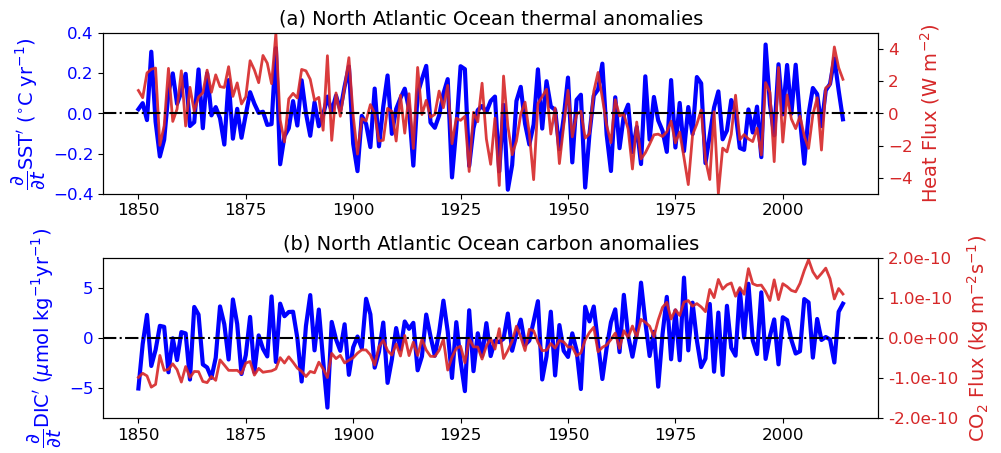

In [24]:
col = plt.cm.tab10(np.linspace(0.,0.35,4))

grid = plt.GridSpec(2, 1, wspace=0.3, hspace=0.4)
fig = plt.figure(figsize=[10,5])

# temperature and heat flux time-series
ax = fig.add_subplot(grid[0, 0])

#var = ds['thetao']
#var = var.groupby('time.year').mean()
var = ds['thetao'].isel(time=slice(11,1980,12)) - ds['thetao'].isel(time=slice(0,1980,12)).drop('time')

flux = ds['hfds']
flux = flux.groupby('time.year').mean()

ax.plot(flux['year'], var, lw=3., color='blue')
ax.set_ylabel(r'$\dfrac{\partial}{\partial t}$SST$^{\prime}$ ($^{\circ}$C yr$^{-1}$)', fontsize = 14, color='blue')
plt.yticks(fontsize = 12, color='blue')
plt.xticks(fontsize = 12)
ax.set_ylim([-0.4, 0.4])
ax.set_title('(a) North Atlantic Ocean thermal anomalies', fontsize = 14)

ax2=ax.twinx()
ax2.plot(flux['year'], flux, lw=2., color=col[3], alpha=0.9)
ax2.set_ylim([-5., 5.])
ax2.axhline(y=0., ls='-.', color='k')
plt.yticks(fontsize = 12, color=col[3])
ax2.set_ylabel(r'Heat Flux (W m$^{-2}$)', fontsize = 14, color=col[3])

# DIC and co2 flux time-series
ax = fig.add_subplot(grid[1, 0])

#var = ds['dissic']
#var = var.groupby('time.year').mean()
var = ds['dissic'].isel(time=slice(11,1980,12)) - ds['dissic'].isel(time=slice(0,1980,12)).drop('time')

flux = ds['fgco2']
flux = flux.groupby('time.year').mean()

ax.plot(flux['year'], var*1000., lw=3., color='blue')
ax.set_ylabel(r'$\dfrac{\partial}{\partial t}$DIC$^{\prime}$ ($\mu$mol kg$^{-1}$yr$^{-1}$)', fontsize = 14, color='blue')
plt.yticks(fontsize = 12, color='blue')
plt.xticks(fontsize = 12)
ax.set_ylim([-8., 8.])
ax.set_title('(b) North Atlantic Ocean carbon anomalies', fontsize = 14)

ax2=ax.twinx()
ax2.plot(flux['year'], flux, lw=2., color=col[3], alpha=0.9)
ax2.set_ylim([-2.e-10, 2.e-10])
ax2.axhline(y=0., ls='-.', color='k')
plt.yticks(fontsize = 12, color=col[3])
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1e'))
ax2.set_ylabel(r'CO$_2$ Flux (kg m$^{-2}$s$^{-1}$)', fontsize = 14, color=col[3])

fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Timeseries_Atlantic_2.pdf', 
            dpi=300,bbox_inches='tight');


## Figure: NAO timeseries and ensembles. Maps of surface temperatures and DIC anomaliee

In [25]:
ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/")
dir_list = glob.glob(ppdir + "r*")

var_list = ['thetao', 'so', 'dissic', 'mlotst']

ds_map = []
for var in var_list:
    d = xr.open_dataset(ppdir + "all_ensembles/Annual_maps/" + var + ".nc")
    ds_map.append(d)

ds_map = xr.merge(ds_map)

In [27]:
comp_nao = xr.open_dataset(ppdir + "/all_ensembles/Timeseries/Depth_time_thetao.nc")
comp_nao = comp_nao.get(['NAO_station', 'NAO_station_standard_error', 'NAO_station_confidence_lower',
                         'NAO_station_confidence_upper'])
ds_NAO = xr.open_dataset(ppdir + "/r2i1p1f2/Timeseries/NAO_SLP.nc")

ds_basin = xr.open_mfdataset("/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl" + 
                             "/r1i1p1f2/Ofx/basin/gn/latest/*nc")
ds_basin = ds_basin.rename({'i':'x','j':'y'})
ds_basin = ds_basin.isel(x=slice(180, 320), y=slice(180, 320))

In [30]:
# Remove climatology and linear trends
NAO = detrend(ds_NAO['NAO_station']/100., ['time'])
NAO_clim = NAO.groupby('time.month').mean('time').compute()
NAO = NAO.groupby('time.month') - NAO_clim

NAO = NAO.isel(time=slice(2,len(NAO.time)-1)) # get rid of first Jan-Feb and last Dec for seasonal avg
NAO_season = NAO.resample(time='QS-DEC').mean('time')

nao_cut_coef = 2.0 # 1 for outside 1 x sigma and 2 for outside 2 x sigma
nao_cut = nao_cut_coef * NAO_season.std('time', skipna=True).values
nao_DJF = NAO_season.sel(time = NAO_season['time.season'] == 'DJF')

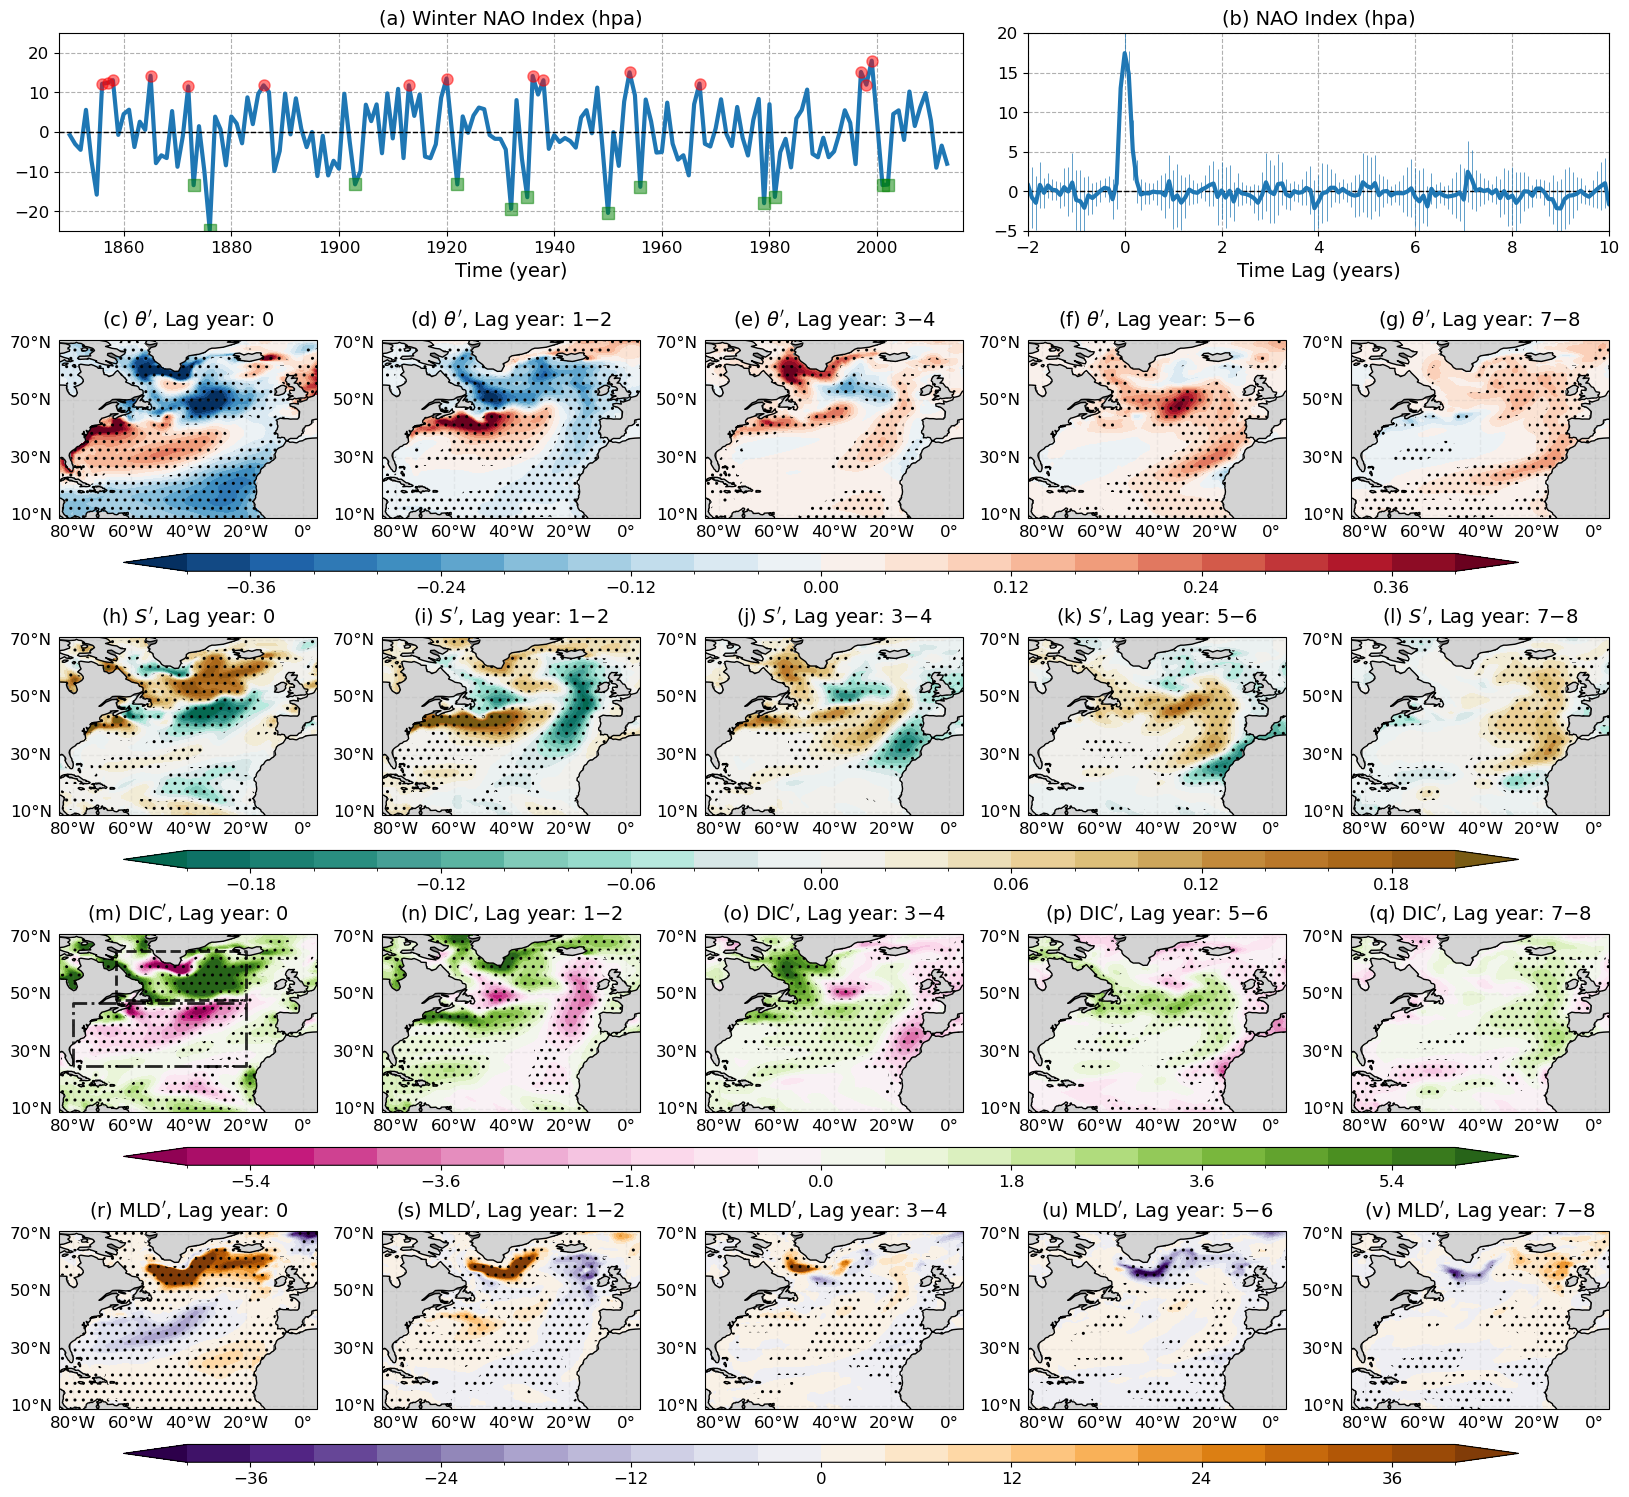

In [32]:
fs = 14

grid1 = plt.GridSpec(5, 5, wspace=0.25, hspace=0.5)
fig = plt.figure(figsize=[20,18])

# Observed NAO 
ax = fig.add_subplot(grid1[0, 0:3])
ax.plot(nao_DJF['time.year'], nao_DJF, lw=3.)

yr_ind1, yr_ind2 = (1., 1.)
for year in range(1 + 5, len(nao_DJF['time']) - 5):
    if(nao_DJF.isel(time=year) >= nao_cut):
        ax.plot(nao_DJF['time.year'].isel(time=year), nao_DJF.isel(time=year), 'o', ms=8, color='red', alpha=0.5)
    elif(nao_DJF.isel(time=year) <= -nao_cut):
        ax.plot(nao_DJF['time.year'].isel(time=year), nao_DJF.isel(time=year), 's', ms=8, color='green', alpha=0.5)

ax.axhline(y=0, ls='--', lw=1, color='k')
ax.set_ylim([-25, 25.]);
ax.set_xlim([1848., 2016.])
ax.set_title('(a) Winter NAO Index (hpa)', fontsize=fs)
plt.xticks(fontsize=fs-2); plt.yticks(fontsize=fs-2);
ax.grid('on', ls='--')
ax.set_xlabel(r'Time (year)', fontsize=fs)

# NAO composite
ax = fig.add_subplot(grid1[0, 3:])
tmp = comp_nao['NAO_station'] / 100.
tmp_err = (comp_nao['NAO_station_confidence_upper'] - comp_nao['NAO_station_confidence_lower']) / 100.

tim = comp_nao['time']/12. - 6. + 36./12.
ax.errorbar(tim, tmp, yerr = tmp_err, lw=3., elinewidth=.5)
ax.set_xlim([-2., 10.]);
ax.set_ylim([-5., 20.]);
ax.axhline(y=0, ls='--', lw=1, color='k')
ax.grid('on', ls='--')
plt.xticks(fontsize=fs-2); plt.yticks(fontsize=fs-2);
ax.set_xlabel(r'Time Lag (years)', fontsize=fs)
ax.set_title('(b) NAO Index (hpa)', fontsize=fs)

# Annual surface maps
cfd_per = 1.0 # z-val for confidence interval (Already multiplied in confidence lower - upper, i.e. for 95%)
hatch_dense = 2

lat_lon_ext = [-85., 5., 9., 71.]
cb_range = [0.4, 0.2, 6., 40.]
fac = [1., 1., 1000., 1.] # DIC converted from mol/m^3 to micro mol/kg 
# (mol * 1e6 micro mol / mol *  / (m^3 * 1000 kg/m^3) = 1000 micro mol / kg)  

var_list = ['thetao', 'so', 'dissic', 'mlotst']
cb_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.MPL_PiYG, cmaps.MPL_PuOr_r]

j = 0
for var in var_list:
    for i in range(2,7):
        
        tmp = ds_map[var].isel(year=i).where(ds_basin['basin']>0.) * fac[j]
        tmp_std = (ds_map[var + '_confidence_upper'] - 
                   ds_map[var + '_confidence_lower']).isel(year=i).where(ds_basin['basin']>0.) * fac[j] * 0.5
        # factor of 0.5 is required because confidence_upper - confidence_lower = 4 * standard error for 95% interval
        # Significant anomalies are outside rouhgly 2 * standard error for 95% interval
        
        #tmp_std = (ds_map[var + '_standard_error'] * 2.).isel(year=i).where(ds_basin['basin']>0.) * fac[j]
        
        ax = fig.add_subplot(grid1[j+1, i-2], projection=ccrs.PlateCarree(),facecolor='grey')

        if (var == 'thetao'):
            if(i==2): # add dimensions in title
                titl = r'(c) $\theta^{\prime}$, Lag year: 0'
            else: 
                titl = '(' + chr(97+i) + r') $\theta^{\prime}$, Lag year: ' + str(2*i-4-1) + r'$-$' + str(2*i-4)
        elif(var == 'so'):
            if(i==2):
                titl = r'(h) $S^{\prime}$, Lag year: 0'
            else: 
                titl = '(' + chr(102+i) + r') $S^{\prime}$, Lag year: ' + str(2*i-4-1) + r'$-$' + str(2*i-4)
        elif(var == 'dissic'):
            if(i==2):
                titl = r'(m) DIC$^{\prime}$, Lag year: 0'
            else: 
                titl = '(' + chr(107+i) + r') DIC$^{\prime}$, Lag year: ' + str(2*i-4-1) + r'$-$' + str(2*i-4)
        else:
            if(i==2):
                titl = r'(r) MLD$^{\prime}$, Lag year: 0'
            else: 
                titl = '(' + chr(112+i) + r') MLD$^{\prime}$, Lag year: ' + str(2*i-4-1) + r'$-$' + str(2*i-4)
        
        p = plot_sec(ax, tmp, da_std = tmp_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                     vmin=-cb_range[j], vmax=cb_range[j],  
                     lat_lon_ext = lat_lon_ext, levels = 21, lon='lon', lat='lat', cmap= cb_map[j], 
                     title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
            
        if((i==2) & (var == 'dissic')):
            lab_y = [48., 65., 65., 48., 48.]
            lab_x = [-65., -65., -20., -20., -65.]
            ax.plot(lab_x,lab_y, linestyle='--', lw = 2, color = 'black', alpha = 0.85, transform=ccrs.PlateCarree())
                
            lab_y = [25., 47., 47., 25., 25.]
            lab_x = [-80., -80., -20., -20., -80.]
            ax.plot(lab_x,lab_y, linestyle='-.', lw = 2, color = 'black', alpha = 0.85, transform=ccrs.PlateCarree())
        
    axins = inset_axes(ax, width="90%", height="10%", 
                   loc='lower left', bbox_to_anchor=(-4.75, -0.3, 6., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
    cb.ax.tick_params(labelsize=12)
    
    j = j + 1

#fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Annual_maps.pdf', dpi=300,bbox_inches='tight');
#fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Annual_maps.png', dpi=300,bbox_inches='tight');

## Figure: Composites of temperature and DIC anomalies as a function of depth 

In [33]:
ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/")

var_list = ['thetao', 'dissic', 'so']

ds = []
for var in var_list: 
    ds1 = xr.open_dataset(ppdir + "all_ensembles/Timeseries/Depth_time_" + var + ".nc")
    
    if(var == 'thetao'):
        ds.append(ds1)
    else:
        ds1 = ds1.drop(['NAO_station', 'NAO_station_standard_error', 'NAO_station_confidence_lower',
                         'NAO_station_confidence_upper', 'mlotst_North_Atlantic_Subtropical', 
                        'mlotst_North_Atlantic_Subtropical_confidence_lower', 'mlotst_North_Atlantic_Subtropical_confidence_upper',
                        'mlotst_North_Atlantic_Subtropical_standard_error',
                        'mlotst_North_Atlantic_Subpolar', 'mlotst_North_Atlantic_Subpolar_standard_error',
                        'mlotst_North_Atlantic_Subpolar_confidence_lower', 'mlotst_North_Atlantic_Subpolar_confidence_upper'
                       ])
        ds.append(ds1)

ds = xr.merge(ds)

In [34]:
ds_volume = xr.open_dataset(ppdir + "all_ensembles/Cell_volume.nc")

ds = xr.merge([ds, ds_volume.drop('time')])

print(ds)

<xarray.Dataset>
Dimensions:                                             (time: 264, lev: 75)
Coordinates:
  * lev                                                 (lev) float64 0.5058 ...
    month                                               (time) int64 1 2 ... 12
Dimensions without coordinates: time
Data variables: (12/48)
    thetao_North_Atlantic_Subpolar                      (time, lev) float32 ...
    thetao_North_Atlantic_Subpolar_standard_error       (time, lev) float32 ...
    thetao_North_Atlantic_Subpolar_confidence_lower     (time, lev) float32 ...
    thetao_North_Atlantic_Subpolar_confidence_upper     (time, lev) float32 ...
    mlotst_North_Atlantic_Subpolar                      (time) float32 ...
    mlotst_North_Atlantic_Subpolar_standard_error       (time) float32 ...
    ...                                                  ...
    so_North_Atlantic_Subtropical_confidence_lower      (time, lev) float32 ...
    so_North_Atlantic_Subtropical_confidence_upper      (tim

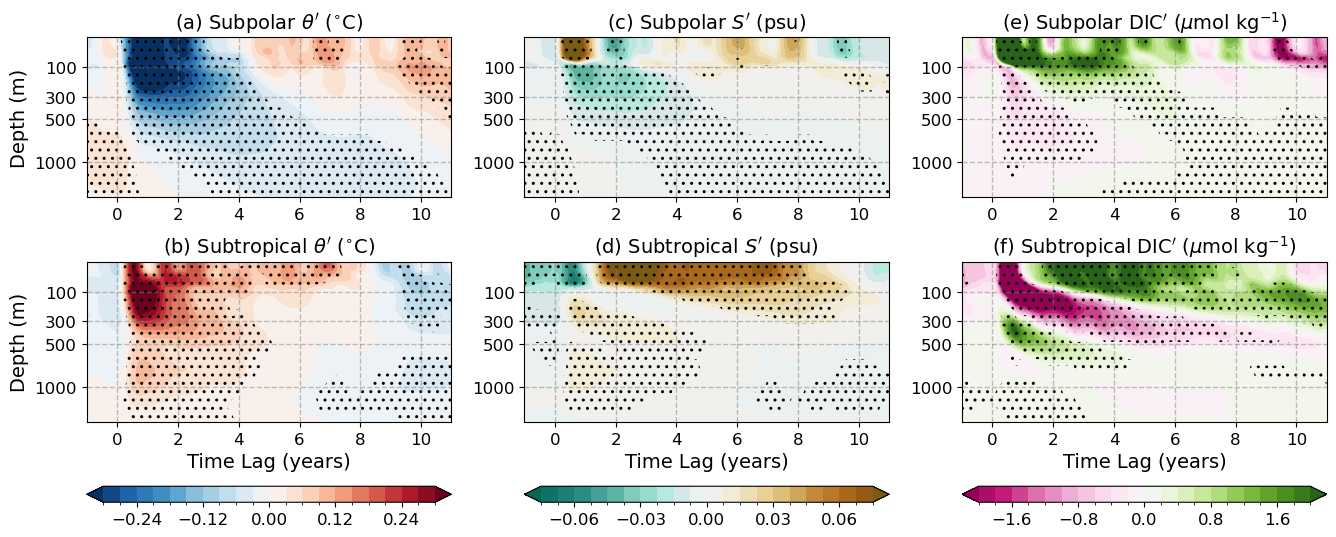

In [35]:
fs = 14

grid1 = plt.GridSpec(2, 3, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[16,5])

fac = [1., 1., 1000.]
cb_range = [0.3, 0.075, 2.0]

var_list = ['thetao', 'so', 'dissic']
region_list = ['_North_Atlantic_Subpolar', '_North_Atlantic_Subtropical']
titl_list = [r'$\theta^{\prime}$ ($^{\circ}$C)', '$S^{\prime}$ (psu)', 'DIC$^{\prime}$ ($\mu$mol kg$^{-1}$)']
titl_list2 = ['Subpolar ', 'Subtropical ']

cb_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.MPL_PiYG]
hatch_dense = 2

for i in range(0,len(var_list)):
    for j in range(0, len(region_list)):

        tim = ds['time']/12. - 6. + 40./12
        tmp = (ds[var_list[i] + region_list[j]] * fac[i] 
               * ds['dz'] / ds['Volume' + region_list[j]])

        tmp = tmp.drop('lev').assign_coords(lev = (ds['lev'].values)**0.6)
        tmp = tmp.assign_coords(time = tim)
        
        ax = fig.add_subplot(grid1[j, i]) 
    
        p = tmp.plot.contourf(ax=ax, x='time', y='lev', levels = 21, vmin = -cb_range[i], vmax = cb_range[i],
                              cmap=cb_map[i], add_labels=False, add_colorbar=False, extend='both')

        # standard error
        tmp_cfd = (ds[var_list[i] + region_list[j] + '_confidence_upper'] - 
                   ds[var_list[i] + region_list[j] + '_confidence_lower'])*0.5
    
        tmp_cfd = tmp_cfd * fac[i] * ds['dz'] / ds['Volume' + region_list[j]]
        tmp_cfd = tmp_cfd.drop('lev').assign_coords(lev = (ds['lev'].values)**0.6)
        tmp_cfd = tmp_cfd.assign_coords(time = tim)
    
        ax.contourf(tmp['time'], tmp['lev'], (np.abs(tmp.transpose()) > np.abs(tmp_cfd.transpose())), colors='none', 
                    levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'], extend='upper')

        plt.yticks((np.array([100.,  300., 500., 1000., 2500., 4000.]))**0.6, 
                   [r'100', r'300', r'500', r'1000', r'2500', r'4000'])
        ax.set_ylim([1., 1500.**0.6])
        ax.set_xlim([-1., 11.])

        if(i==0):
            ax.set_ylabel('Depth (m)', fontsize=14)
        if(j==1):
            ax.set_xlabel('Time Lag (years)', fontsize=14)
        titl = r'(' + chr(97+j+i*2) + r') ' + titl_list2[j] + titl_list[i]
        ax.set_title(titl, fontsize=14)
        plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
        ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
        plt.gca().invert_yaxis()

    axins = inset_axes(ax, width="100%", height="10%",  
                   loc='lower left', bbox_to_anchor=(0., -0.5, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal",
                     ticks=[-cb_range[i]*0.8, -cb_range[i]*0.4, 0, cb_range[i]*0.4, cb_range[i]*0.8])
    cb.ax.tick_params(labelsize=12)

#fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Tracer_depth_time.pdf', dpi=300,bbox_inches='tight');
#fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Tracer_depth_time.png', dpi=300,bbox_inches='tight');

## Figure: Climate-mean tracer profiles and meridional transport

In [36]:
ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/" + "r2i1p1f2/")

ds = xr.open_dataset(ppdir + "Climatology_thetao_DIC.nc")

ds_basin = xr.open_mfdataset("/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl" + 
                             "/r1i1p1f2/Ofx/basin/gn/latest/*nc")
ds_basin = ds_basin.rename({'i':'x','j':'y'})
ds_basin = ds_basin.isel(x=slice(180, 310), y=slice(130, 300))

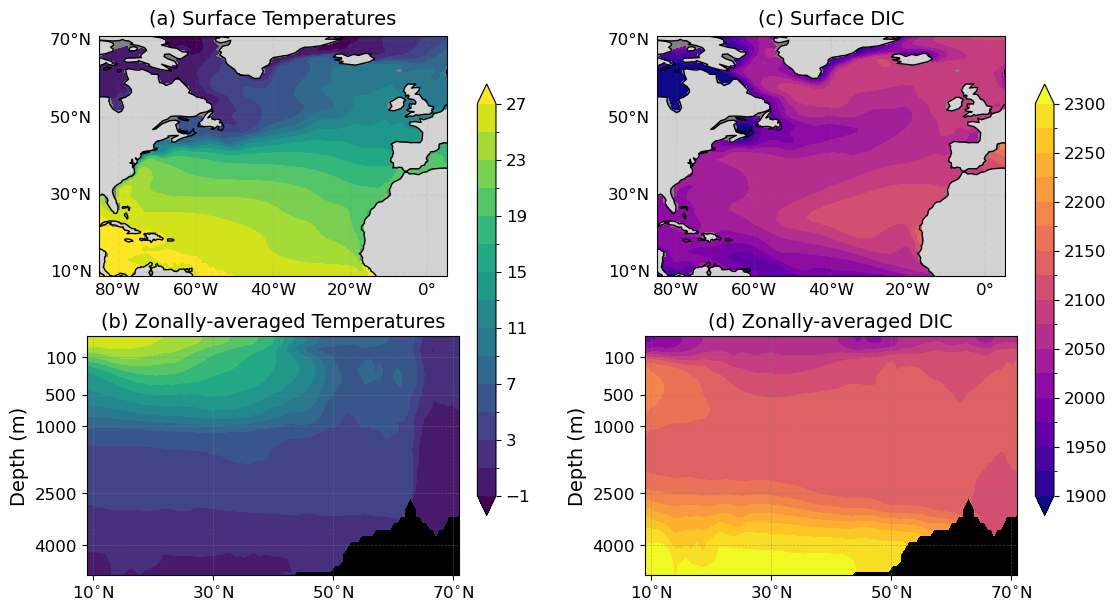

In [37]:
grid1 = plt.GridSpec(2, 2, wspace=0.5, hspace=0.25)
fig = plt.figure(figsize=[12,7])

lat_lon_ext = [-85., 5., 9., 71.]

# -------- tracer surface fields -------- 

# temperatures
ax = fig.add_subplot(grid1[0, 0],projection=ccrs.PlateCarree(),facecolor='grey')

tmp = ds['thetao'].isel(lev=0).where(ds_basin['basin']>0.)
tmp = tmp.assign_coords({'lat': ds_basin['latitude'], 'lon': ds_basin['longitude']})

p = plot_sec2(ax, tmp, vmin=-1., vmax=27.,  lat_lon_ext = lat_lon_ext, levels = 15, lon='lon', lat='lat', cmap= 'viridis', 
                     title=' ', colorbar=False, y_lab = True, x_lab = True)
ax.set_title('(a) Surface Temperatures', fontsize=14)

ax = fig.add_subplot(grid1[1, 0],facecolor='black')

tmp = ds['thetao'].where(ds_basin['basin']>0.)
dx = ds['dx'] * tmp / tmp # make dx 3D
tmp = (tmp * dx).sum('x') / dx.sum('x') 
lat = (ds_basin['latitude'] * ds['dx']).sum('x') / ds['dx'].sum('x')

tmp = tmp.assign_coords({'lat': lat})
tmp = tmp.drop('lev').assign_coords(lev = (ds['lev'].values)**0.6)
tmp = tmp.isel(y=slice(10,-4))

p = tmp.plot.contourf(ax=ax, x='lat', y='lev', levels = 15, vmin=-1., vmax=27.,
                              cmap='viridis', add_labels=False, add_colorbar=False, extend='both')

plt.yticks((np.array([100., 500., 1000., 2500., 4000.]))**0.6, 
                   [r'100', r'500', r'1000', r'2500', r'4000'])
plt.xticks((np.array([10., 30., 50., 70.])), 
                   [r'10$^{\circ}$N', r'30$^{\circ}$N', r'50$^{\circ}$N', r'70$^{\circ}$N'])
ax.set_ylim([1., 5000.**0.6])
ax.set_xlim([9., 71.])
ax.set_ylabel('Depth (m)', fontsize=14)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=0.5)
ax.set_title('(b) Zonally-averaged Temperatures', fontsize=14)
plt.gca().invert_yaxis()

axins = inset_axes(ax, width="5%", height="90%",  
                   loc='lower left', bbox_to_anchor=(1.05, 0.25, 1., 2.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both')
cb.ax.tick_params(labelsize=12)

# DIC
ax = fig.add_subplot(grid1[0, 1],projection=ccrs.PlateCarree(),facecolor='grey')

tmp = ds['dissic'].isel(lev=0).where(ds_basin['basin']>0.) * 1000.
tmp = tmp.assign_coords({'lat': ds_basin['latitude'], 'lon': ds_basin['longitude']})

p = plot_sec(ax, tmp, vmin=1900., vmax=2300.,  lat_lon_ext = lat_lon_ext, levels = 17, lon='lon', lat='lat', cmap= 'plasma', 
                     title=' ', colorbar=False, y_lab = True, x_lab = True)
ax.set_title('(c) Surface DIC', fontsize=14)

ax = fig.add_subplot(grid1[1, 1],facecolor='black')

tmp = ds['dissic'].where(ds_basin['basin']>0.) * 1000.
dx = ds['dx'] * tmp / tmp # make dx 3D
tmp = (tmp * dx).sum('x') / dx.sum('x') 
lat = (ds_basin['latitude'] * ds['dx']).sum('x') / ds['dx'].sum('x')

tmp = tmp.assign_coords({'lat': lat})
tmp = tmp.drop('lev').assign_coords(lev = (ds['lev'].values)**0.6)
tmp = tmp.isel(y=slice(10,-4))

p = tmp.plot.contourf(ax=ax, x='lat', y='lev', levels = 17, vmin=1900., vmax=2300.,
                              cmap='plasma', add_labels=False, add_colorbar=False, extend='both')

plt.yticks((np.array([100., 500., 1000., 2500., 4000.]))**0.6, 
                   [r'100', r'500', r'1000', r'2500', r'4000'])
plt.xticks((np.array([10., 30., 50., 70.])), 
                   [r'10$^{\circ}$N', r'30$^{\circ}$N', r'50$^{\circ}$N', r'70$^{\circ}$N'])
ax.set_ylim([1., 5000.**0.6])
ax.set_xlim([9., 71.])
ax.set_ylabel('Depth (m)', fontsize=14)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=0.5)
ax.set_title('(d) Zonally-averaged DIC', fontsize=14)
plt.gca().invert_yaxis()

axins = inset_axes(ax, width="5%", height="90%",  
                   loc='lower left', bbox_to_anchor=(1.05, 0.25, 1., 2.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both')
cb.ax.tick_params(labelsize=12)

#fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Climatology_DIC_Theta.pdf', 
#            dpi=300,bbox_inches='tight');
#fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Climatology_DIC_Theta.png', 
#            dpi=300,bbox_inches='tight');

## Figure: Spatial maps of phosphorus, chlorophyll (averaged in upper 100 m) and downward organic carbon particulate flux at 100 m depth 

In [38]:
ppdir = ("/gws/nopw/j04/unicorns/carbon_add_redis" + 
         "/Fast_SLow_NAO/MOHC/UKESM1-0-LL/historical/")
var_list = ['po4', 'epc100', 'chl']

ds_map = []
for var in var_list:
    if(var == 'epc100'):
        d = xr.open_dataset(ppdir + "all_ensembles/Annual_maps/" + var + ".nc")
    else:
        d = xr.open_dataset(ppdir + "all_ensembles/Annual_maps/" + var + "_100.nc")
    ds_map.append(d)

ds_map = xr.merge(ds_map)

ds_basin = xr.open_mfdataset("/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl" + 
                             "/r1i1p1f2/Ofx/basin/gn/latest/*nc")
ds_basin = ds_basin.rename({'i':'x','j':'y'})
ds_basin = ds_basin.isel(x=slice(180, 320), y=slice(180, 320))

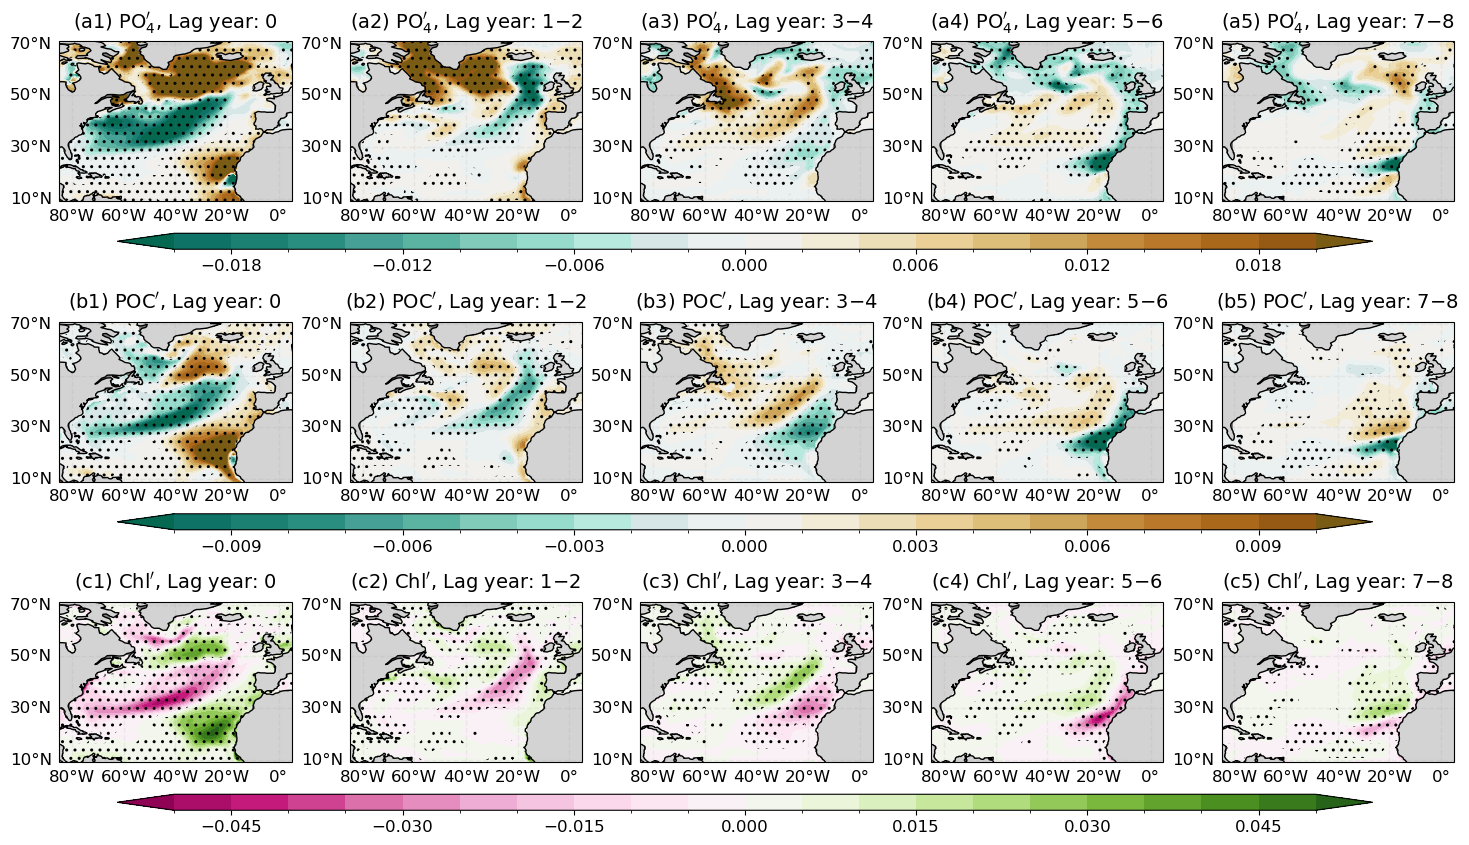

In [46]:
fs = 14

grid1 = plt.GridSpec(5, 5, wspace=0.25, hspace=0.5)
fig = plt.figure(figsize=[18,17])

cfd_per = 1.0 # z-val for confidence interval (Already multiplied in confidence lower - upper, i.e. for 95%)
hatch_dense = 2

lat_lon_ext = [-85., 5., 9., 71.]
#cb_range = [50., 0.6, 0.02, 3., 3., 5.e-2]
#fac = [1., 1000., 1000., 1000., 1.e6, 1.e6] 

# o2sat cmip output diagnostics have error by a factor of 1000, so used 1e6 to account for the factor

#var_list = ['mlotst', 'no3', 'po4', 'o2', 'o2sat', 'chl']
#titl_list = [r'MLD$^{\prime}$', r'NO$_3^{\prime}$', r'PO$_4^{\prime}$', r'O$_2^{\prime}$', 
#             r'O$_2^{\prime}(sat)$', r'Chl$^{\prime}$']
#cb_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.NEO_div_vegetation_c_r, 
#          cmaps.MPL_PiYG, cmaps.MPL_PiYG, cmaps.MPL_PiYG]

var_list = ['po4', 'epc100', 'chl']
cb_map = [cmaps.NEO_div_vegetation_c_r,
          cmaps.NEO_div_vegetation_c_r, cmaps.MPL_PiYG]
titl_list = [r'PO$_4^{\prime}$', r'POC$^{\prime}$', r'Chl$^{\prime}$']
cb_range = [0.02, 1.e-2, 5.e-2]
fac = [1000., 1.e6, 1.e6] 
# convert PO4 to micromol/kg from mol/m^3, chl to micro-g/kg from kg/m^3, POC to micromol/m^2/s from mol/m^2/s

j = 0
for var in var_list:
    for i in range(2,7):
        
        tmp = ds_map[var].isel(year=i).where(ds_basin['basin']>0.) * fac[j]
        tmp_std = (ds_map[var + '_confidence_upper'] - 
                   ds_map[var + '_confidence_lower']).isel(year=i).where(ds_basin['basin']>0.) * fac[j] * 0.5
        
        ax = fig.add_subplot(grid1[j, i-2], projection=ccrs.PlateCarree(),facecolor='grey')

        if(i==2):
            titl = r'(' + chr(97+j) + str(i-1) + ') ' + titl_list[j] + ', Lag year: 0'
        else:
            titl = (r'(' + chr(97+j) + str(i-1) +') ' + titl_list[j] + 
                    ', Lag year: ' + str(2*i-4-1) + r'$-$' + str(2*i-4))
        
        p = plot_sec(ax, tmp, da_std = tmp_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                     vmin=-cb_range[j], vmax=cb_range[j],  
                     lat_lon_ext = lat_lon_ext, levels = 21, lon='lon', lat='lat', cmap= cb_map[j], 
                     title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
        
    axins = inset_axes(ax, width="90%", height="10%", 
                   loc='lower left', bbox_to_anchor=(-4.75, -0.3, 6., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
    cb.ax.tick_params(labelsize=12)
    
    j = j + 1

fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Nutrient_chl_maps.pdf', 
            dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_Carbon_Thermal_2024/Nutrient_chl_maps.png', 
            dpi=300,bbox_inches='tight');